In [1]:
import os
path = os.getcwd()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix
def cm_plot(y, yp):
    cm = confusion_matrix(y, yp)

    plt.matshow(cm, cmap = plt.cm.Blues_r)
    plt.colorbar()

    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(
                cm[x, y],
                xy = (x, y),
                horizontalalignment = 'center',
                verticalalignment = 'center'
            )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

6-1 拉格朗日补插用电量空值

In [4]:
inputfile = path + '/data/missing_data.xls'
outputfile = path + '/tmp/missing_data_processed.xls'
# 读入三个用户一个月工作日用电量数据
data = pd.read_excel(inputfile, header = None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
0    19 non-null float64
1    17 non-null float64
2    17 non-null float64
dtypes: float64(3)
memory usage: 584.0 bytes


In [5]:
data

,0,1,2
0,235.8333,324.0343,478.3231
1,236.2708,325.6379,515.4564
2,238.0521,328.0897,517.0909
3,235.9063,NaN,514.8900
4,236.7604,268.8324,NaN
5,NaN,404.0480,486.0912
6,237.4167,391.2652,516.2330
7,238.6563,380.8241,NaN
8,237.6042,388.0230,435.3508
9,238.0313,206.4349,487.6750


In [6]:
# 拉格朗日补插空值
from scipy.interpolate import lagrange

# 自定义列向量插值函数
# s为列向量，n为被插值的位置，k为取前后的数据个数，默认为5
def ployinterp_column(s, n, k = 5):
    y = s[list(range(n - k, n)) + list(range(n + 1, n + 1 + k))]  # 取数
    y = y[y.notnull()]  # 剔除空值
    return lagrange(y.index, list(y))(n)  # 插值并返回插值结果

# 逐个元素判断是否需要插值
for i in data.columns:
    for j in range(len(data)):
        if (data[i].isnull())[j]:
            data[i][j] = ployinterp_column(data[i], j)

data.to_excel(outputfile, header = None, index = False)
data    # 补插后的三个用户一个月工作日用电量数据

D:\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,0,1,2
0,235.833300,324.034300,478.323100
1,236.270800,325.637900,515.456400
2,238.052100,328.089700,517.090900
3,235.906300,203.462116,514.890000
4,236.760400,268.832400,493.352591
5,237.151181,404.048000,486.091200
6,237.416700,391.265200,516.233000
7,238.656300,380.824100,493.342382
8,237.604200,388.023000,435.350800
9,238.031300,206.434900,487.675000


6-2 构建窃漏电用户识别模型

In [7]:
# 读取专家样本数据
datafile = path + '/data/model.xls'
data_model = pd.read_excel(datafile)
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 4 columns):
电量趋势下降指标    291 non-null int64
线损指标        291 non-null int64
告警类指标       291 non-null int64
是否窃漏电       291 non-null int64
dtypes: int64(4)
memory usage: 9.2 KB


In [8]:
# 切割数据集为训练集与测试集
from sklearn.cross_validation import train_test_split
# 设置训练数据比8:2
train, test = train_test_split(data_model, test_size = 0.2)

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
train[train.columns[0:3]][:5]

,电量趋势下降指标,线损指标,告警类指标
220,0,0,2
164,1,1,1
18,8,1,4
79,0,0,1
210,1,1,1


6-2-1 构建LM神经网络模型

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/1000
 56/232 [======>.......................] - ETA: 5s - loss: 0.7097

D:\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.172273). Check your callbacks.
  % delta_t_median)


232/232 [==============================] - 2s 9ms/step - loss: 0.6092
Epoch 2/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.5759
Epoch 3/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.5459
Epoch 4/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.5162
Epoch 5/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.4891
Epoch 6/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.4642
Epoch 7/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.4371
Epoch 8/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.4002
Epoch 9/1000
232/232 [==============================] - 1s 4ms/step - loss: 0.3797
Epoch 10/1000
232/232 [==============================] - 1s 4ms/step - loss: 0.3618
Epoch 11/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.3479
Epoch 12/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.3307
Epoch 13/1000


D:\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214511). Check your callbacks.
  % delta_t_median)
D:\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.438655). Check your callbacks.
  % delta_t_median)


132/232 [================>.............] - ETA: 11s - loss: 0.1838

D:\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.610192). Check your callbacks.
  % delta_t_median)
D:\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.599561). Check your callbacks.
  % delta_t_median)
D:\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221262). Check your callbacks.
  % delta_t_median)


232/232 [==============================] - 16s 68ms/step - loss: 0.1924
Epoch 90/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1907
Epoch 91/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1910
Epoch 92/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1824
Epoch 164/1000
232/232 [==============================] - 1s 6ms/step - loss: 0.1846
Epoch 165/1000
232/232 [==============================] - 1s 6ms/step - loss: 0.1830
Epoch 166/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1832
Epoch 167/1000
232/232 [==============================] - 1s 4ms/step - loss: 0.1843
Epoch 168/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1849
Epoch 169/1000
232/232 [==============================] - 1s 6ms/step - loss: 0.1840
Epoch 170/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1850
Epoch 171/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1

232/232 [==============================] - 1s 5ms/step - loss: 0.1728
Epoch 992/1000
232/232 [==============================] - 1s 6ms/step - loss: 0.1732
Epoch 993/1000
232/232 [==============================] - 1s 6ms/step - loss: 0.1745
Epoch 994/1000
232/232 [==============================] - 2s 7ms/step - loss: 0.1708
Epoch 995/1000
232/232 [==============================] - 1s 6ms/step - loss: 0.1717
Epoch 996/1000
232/232 [==============================] - 1s 4ms/step - loss: 0.1712
Epoch 997/1000
232/232 [==============================] - 1s 4ms/step - loss: 0.1718
Epoch 998/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1710
Epoch 999/1000
232/232 [==============================] - 1s 5ms/step - loss: 0.1706
Epoch 1000/1000
232/232 [==============================] - 2s 8ms/step - loss: 0.1754


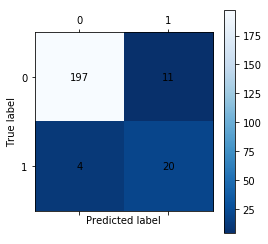

In [ ]:
# 导入深度学习神经网络模块
from keras.models import Sequential              # 导入LM初始化函数
from keras.layers.core import Dense, Activation  # 导入LM层函数、激活函数

# 构建LM神经网络模型村塾路径
netfile = path + '/tmp/net.model'
# 建立神经网络
net = Sequential()
net.add(Dense(input_dim = 3, units = 10))  # 添加输入层（3节点）到隐藏层（10节点）的连接
net.add(Activation('relu'))     # 隐藏层使用relu激活函数
net.add(Dense(input_dim = 10, units = 1))  # 添加隐藏层（10节点）到输出层（1节点）的连接
net.add(Activation('sigmoid'))  # 输出层使用sigmoid激活函数
net.compile(                    # 编译模型，使用adam方法求解
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    sample_weight_mode = "binary"
)  

# 训练神经网络模型
net.fit(train[train.columns[:3]], train[train.columns[3]], epochs = 1000, batch_size = 1)
net.save_weights(netfile)    # 保存模型

# 训练集预测的混淆矩阵可视化结果
predict_result_train = net.predict_classes(train[train.columns[:3]]).reshape(len(train))  # 预测结果变形
cm_plot(train[train.columns[3]], predict_result_train).show()

6-2-2 构建CART决策树模型

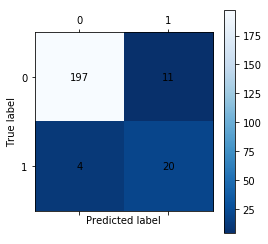

In [ ]:
from sklearn.tree import DecisionTreeClassifier  # 打导入决策树模型
from sklearn.externals import joblib             # 保存模型

# 构建CART决策树模型
treefile = path + '/tmp/tree.pkl'
tree = DecisionTreeClassifier()
tree.fit(train[train.columns[:3]], train[train.columns[3]])
joblib.dump(tree, treefile)

# 训练集预测的混淆矩阵可视化结果
predict_result_train = tree.predict(train[train.columns[:3]])
cm_plot(train[train.columns[3]], predict_result_train).show()

6-3 模型评价

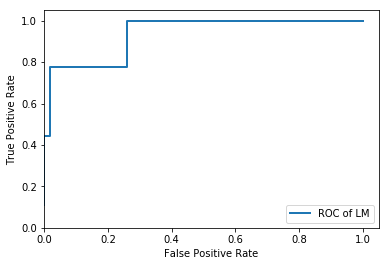

[9.9623692e-01 7.9805821e-01 7.6564771e-01 6.6927785e-01 2.9875457e-01
 1.6010663e-01 1.1836974e-01 9.9801347e-02 8.3339632e-02 7.0267990e-02
 5.0245959e-02 2.9093221e-02 1.5661929e-02 1.0309638e-02 2.8997336e-03
 1.9671163e-03 1.3340489e-03 2.0369113e-04 1.1995856e-05 6.2408014e-07
 9.3191240e-08]


In [ ]:
# 测试集预测LM模型的ROC曲线可视化结果
from sklearn.metrics import roc_curve
predict_result_LM = net.predict(test[test.columns[:3]]).reshape(len(test))
fpr, tpr, thresholds = roc_curve(test[test.columns[3]], predict_result_LM, pos_label = 1)
plt.plot(fpr, tpr, linewidth = 2, label = 'ROC of LM')  # 绘制ROC曲线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1.05)    # y轴边界范围
plt.xlim(0, 1.05)
plt.legend(loc = 4)  # 图例
plt.show()
print(thresholds)

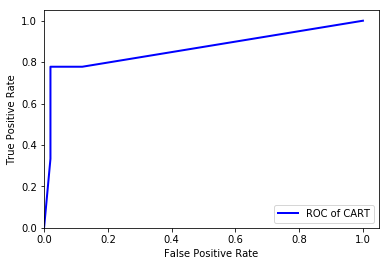

[2.         1.         0.66666667 0.6        0.5        0.16666667
 0.11111111 0.        ]


In [ ]:
# 测试集预测CART模型的ROC曲线可视化结果
predict_result_CART = tree.predict_proba(test[test.columns[:3]])[:, 1]
fpr, tpr, thresholds = roc_curve(test[test.columns[3]], predict_result_CART, pos_label = 1)
plt.plot(fpr, tpr, linewidth = 2, label = 'ROC of CART', color = 'blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.legend(loc = 4)
plt.show()
print(thresholds)